In [1]:
import netket as nk
import platform

import json

import numpy as np
import matplotlib.pyplot as plt
import time

import jax
import jax.numpy as jnp

c:\Users\navan\anaconda3\envs\nqs\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


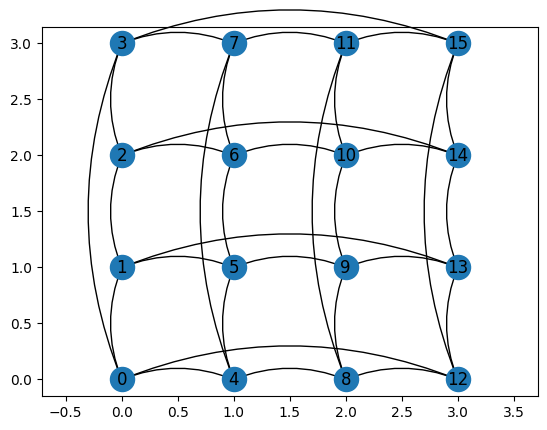

In [2]:
# Defining Ising model on a 2D-lattice with PBC

L = 4
g = nk.graph.Hypercube(length=L,n_dim=2,pbc=True) # defining a lattice of 16 sites and hypercube geometry
g.draw();

In [3]:
# Define the Hilber Space based on this graph and we impose to have a fixed magnetization of zero.
hi = nk.hilbert.Spin(s=1/2,N=g.n_nodes)

# construction of the Hamiltonian.
hamiltonian = nk.operator.LocalOperator(hi) 

print(hamiltonian.to_sparse()) 

The Hamiltonian we defined have all the elements zero. We need to use `nk.operator.spin` or `nk.operator.boson` to create the fundamental operators that can be used to build arbitrary observables and Hamiltonians.

These functions return an object of type `LocalOperator`, which behaves as some sort of sparse matrix that is optimized in the context of VMC. A LocalOperator can efficiently represent an operator that acting on 1 or 2 qubits but not that which acts on many qubits at once.

$$\mathcal{H} = -h\sum_{i}\sigma_{i}^{x} + J\sum_{<i,j>} \sigma_{i}^{(z)}\sigma_{j}^{(z)}$$

where we take $J=1$ and $h=1$.

In [4]:
for site in g.nodes():
    hamiltonian -= 1.0*nk.operator.spin.sigmax(hi,site) # single site operators

for (i,j) in g.edges():
    hamiltonian+=nk.operator.spin.sigmaz(hi,i)@nk.operator.spin.sigmaz(hi,j)

In [5]:
# validation of the Hamiltonian

hamiltonian_correct = nk.operator.Ising(hi,g,h=1.0,J=1.0)
assert np.sum(np.abs(hamiltonian_correct.to_sparse() - hamiltonian.to_sparse())**2) < 1e-5

The operators is nektet is implemented in `numba` and they are not compatiable with `jax.jit`. To mak it compatible jax we can do the following convertion:

In [6]:
hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()
hamiltonian_jax.to_sparse()

BCOO(float64[65536, 65536], nse=1114112)

## Exact diagonalization

In [7]:
from scipy.sparse.linalg import eigsh

In [8]:
H = hamiltonian.to_sparse()
eigvals,eigvecs = eigsh(H,k=2,which='SA') # find minimum algebraic values
e_gs,psi_gs = eigvals[0],eigvecs[:,1].reshape(-1) # flatten the array

In [9]:
e_gs

-34.010597550846256

In [10]:
psi_gs

array([-1.07648406e-14, -3.06156708e-07,  3.06156619e-07, ...,
       -3.06156708e-07,  3.06156619e-07, -1.03683597e-14])

In [11]:
assert e_gs.shape == ()
assert psi_gs.shape == (hi.n_states, )
assert -34.01060 < e_gs < -34.01059

In [12]:
## Another approach

e_gs,psi_gs = nk.exact.lanczos_ed(hamiltonian,k=1,compute_eigenvectors=True)

print(e_gs,psi_gs)

[-34.01059755] [[8.39639634e-08]
 [3.46406982e-07]
 [3.46406937e-07]
 ...
 [3.46406982e-07]
 [3.46406937e-07]
 [8.39639627e-08]]


## Variational Ansatz & Variational Energy

### Mean-Field Ansatz

The ansatz chosen for the Ising model is of form:
    $$\langle \sigma_{1}^{z}..\sigma_{N}^{z}|\Psi_{mf}\rangle = \Pi_{i=1}^{N}\Phi(\sigma_{i}^{z})$$
where $\Phi(\sigma^{z})$ is single-spin wavefunctions which is of form:
    $$\Phi(\sigma^{z}) = \sqrt{P(\sigma^{z})} \exp(i\phi(\sigma^{z}))$$
For the normalized single-spin probability we will take the sigmoid form:
$$P(\sigma_{z};\lambda)=\frac{1}{\exp(-\lambda\sigma_{z})}$$

In netket one has to define a variational function approximating the logarithm of the wave-function amplitudes.

$$\langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{mf}} \rangle = \exp\left[\mathrm{Model}(\sigma^{z}_1,\dots \sigma^{z}_N ; \theta ) \right]$$

In [13]:
import flax
# numerical operations in the model should always use jax.numpy instead 
# of numpy because former supports computing derivatives.
import flax.linen as nn
# flax linen is a repositry if layers, initializers and non-linear functions.
# A flax model is a child class of nn.module

class MF(nn.Module):

    @nn.compact
    def __call__(self,x):
        ## __call__(self,x) takes a **batch of states** as input [x.shape= (n_samples,N)]
        ## and should return a vector of n_samples log-amplitudes.

        lam = self.param(
            "lambda",nn.initializers.normal(),(1,),float
            ) # due to translational symmetry all sites will have same lambda
        
        ## self.parm defines a tensor of variational parameters.
        # - arbitrary name to refer the set of parameters.
        # - an initializer used to provide the initial values.
        # - the shape of the tensor.
        # - the dtype of the tensor.

        ## compute the probabilites
        p = nn.log_sigmoid(lam*x)  
        
        # p matrix with dim(N_s, L^2).
        # N_s = number of samples | L^2 = number of sites.
        # MFA is product of wavefunction of individual sites.
        # since we take logarithm wave amplitudes, product gets converted to sum.
        # Thus need to take sum over the row.

        ## sum the output
        return 0.5*jnp.sum(p,axis=-1) # how the normalization factor becomes 0.5

The class we defined contains the set of instruction on how to initialize the parameters and compute the result. To initialize the parmeters we do the following.

In [14]:
model = MF()
key = jax.random.key(0)
parameters = model.init(key,np.random.rand(hi.size)) # initializes the value of lambda
print(parameters)

{'params': {'lambda': Array([-0.02033396], dtype=float64)}}


In [15]:
# generate 4 random inputs

inputs = hi.random_state(jax.random.key(1),(4,))
print(inputs)

[[ 1.  1. -1. -1.  1. -1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1.]
 [ 1. -1.  1.  1.  1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1.  1.]
 [ 1.  1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1. -1. -1.  1.  1.]
 [-1. -1. -1.  1.  1.  1.  1.  1. -1.  1. -1. -1.  1. -1. -1.  1.]]


In [16]:
log_psi = model.apply(parameters,inputs)
print(log_psi) # 4 values since we feed 4 different configurations.

[-5.53542393 -5.57609185 -5.54559091 -5.54559091]


In [17]:
amps = np.exp(log_psi) # exponentiating logarithm of wavefunction amplitudes.
psi = amps/np.linalg.norm(amps,ord=3)

In [18]:
def to_array(model,parameters):
    all_configurations = hi.all_states()
    logpsi = model.apply(parameters,all_configurations)
    exp_psi = jnp.exp(logpsi)
    #psi = exp_psi/jnp.linalg.norm(exp_psi) # ensures sum of the squares of the amplitude = 1 (since we us l2 norm).
    # using L3 norm, then sum of the cube of each element will be 1.
    
    return exp_psi


In [19]:
assert to_array(model, parameters).shape == (hi.n_states, )
assert np.all(to_array(model, parameters) > 0)
np.testing.assert_allclose(np.linalg.norm(to_array(model, parameters)), 1.0)

In [20]:
%timeit to_array(model,parameters)

13.6 ms ± 320 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
to_array_jit = jax.jit(to_array,static_argnames='model')
to_array_jit(model,parameters) # using numpy arrays will throw error.

Array([0.0042355 , 0.00419265, 0.00419265, ..., 0.0036364 , 0.0036364 ,
       0.00359962], dtype=float64)

In [22]:
%timeit to_array_jit(model,parameters)

6.91 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Energy

In [23]:
def compute_energy(model, parameters, hamiltonian):
    psi_gs = to_array(model,parameters)
    energy = psi_gs.conj().T@(hamiltonian@psi_gs) # psi_gs is a column vector.
    return energy

In [24]:
assert compute_energy(model, parameters, hamiltonian.to_sparse()).shape == ()
assert compute_energy(model, parameters, hamiltonian.to_sparse()) < 0

In [25]:
compute_energy_jit = jax.jit(compute_energy, static_argnames="model")

hamiltonian_sparse = hamiltonian.to_sparse()
hamiltonian_jax_sparse = hamiltonian_jax.to_sparse()

%timeit compute_energy(model, parameters, hamiltonian_sparse)
%timeit compute_energy_jit(model, parameters, hamiltonian_jax_sparse)

18.2 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
15 ms ± 571 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Gradient of the Energy

Gradient of energy is calculated by calling `jax.grad(compute_energy,argnums=1)`where argnum signals wrt which argument we want to compute the gradient 

- `argnums=0` - indicates model, which is not an array thus differentiation not possible,
- `argnums=1` - indicates parameters, which is an array thus differentiation is possible.

In [26]:
from functools import partial

@partial(jax.jit, static_argnames='model') # using partial will directly jit the function
def compute_energy_and_gradient(model,parameters,hamiltonian_sparse):
    grad_fun = jax.value_and_grad(compute_energy,argnums=1) 
    return grad_fun(model, parameters, hamiltonian_sparse)

In [27]:
energy,gradient = compute_energy_and_gradient(model,parameters, hamiltonian_jax_sparse)
print(gradient)

{'params': {'lambda': Array([-0.40662741], dtype=float64)}}


### Optimise and look for the ground state

In [28]:
from tqdm import tqdm

model = MF()
parameters = model.init(jax.random.key(0),np.ones((hi.size,)))
logger = nk.logging.RuntimeLog()

In [29]:
parameters['params']['lambda']-0.02

Array([-0.04033396], dtype=float64)

In [30]:
iterations = 100

for i in tqdm(range(iterations)):
    energy,gradient = compute_energy_and_gradient(model,parameters, hamiltonian_jax_sparse)

    parameters = jax.tree_map(lambda p,g: p-0.01*g, parameters,gradient)

    logger(step=i,item={'Energy':energy})
 

100%|██████████| 100/100 [00:02<00:00, 33.53it/s]


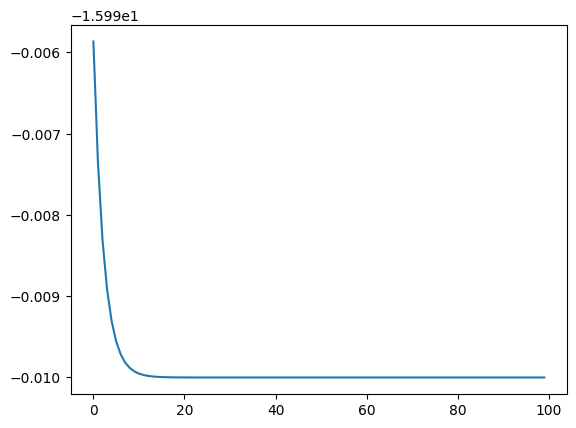

In [31]:
plt.plot(logger.data['Energy']['iters'],logger.data['Energy']['value'])

In [32]:
Eiter = logger.data['Energy']['value']
rel_err = list(map(lambda x: abs(x-e_gs),Eiter))

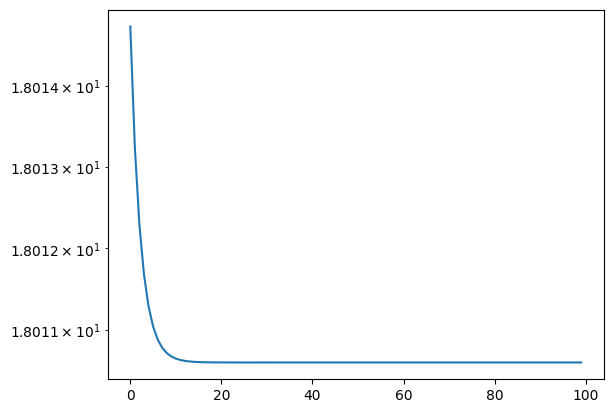

In [33]:
plt.semilogy(logger.data['Energy']['iters'],rel_err);

Ansatz is not giving good results. There is only one parameter, thus it 
gets converged to a suboptimal result.


### Jastrow Ansatz

Jastrow ansatz is defined as:

$$\langle \sigma_{1}^{z}\ldots\sigma_{N}^{z}|\Psi_{jas}\rangle = \exp(\sum_{i,j}\sigma_{i}J_{i,j}\sigma_{j})$$

In [34]:
class Jastrow(nn.Module):
    @nn.compact
    def __call__(self,x):
        nsites = x.shape[-1]
        J = self.param("J",nn.initializers.normal(),(nsites,nsites),float)

        #ensure same data types
        dtype = jax.numpy.promote_types(J.dtype,x.dtype) # promoted data type will be that which can safely represent both.
        J = J.astype(dtype)
        x = x.astype(dtype)

        # make J symmetric - Variational optimisation cannot make J symmetric. 
        J_symm = J.T + J

        res = jnp.einsum("...i,jk,...j->...",x,J_symm,x) # where is exponentiation
        #res = jnp.exp(jnp.einsum("...i,jk,...j->...",x,J_symm,x))
    
        return res


In [35]:
model_jastrow = Jastrow()

one_sample = hi.random_state(jax.random.key(0))
batch_samples = hi.random_state(jax.random.key(0), (5,))
multibatch_samples = hi.random_state(jax.random.key(0), (5,4,))

parameters_jastrow = model_jastrow.init(jax.random.key(0), one_sample)
assert parameters_jastrow['params']['J'].shape == (hi.size, hi.size)
assert model_jastrow.apply(parameters_jastrow, one_sample).shape == () #
assert model_jastrow.apply(parameters_jastrow, batch_samples).shape == batch_samples.shape[:-1]
assert model_jastrow.apply(parameters_jastrow, multibatch_samples).shape == multibatch_samples.shape[:-1]

## Monte Carlo Complications

### Generating Samples

In [36]:
sampler = nk.sampler.MetropolisSampler(
    hi, # the hilbert space to be sampled
    nk.sampler.rules.LocalRule(), # transition rule - flips the spins in the config one by one.
    n_chains=20)

In [37]:
sampler_state = sampler.init_state(model,parameters,seed=1) # contains mutable state and rng of the sampler.
sampler_state = sampler.reset(model,parameters,sampler_state) # everytime parameters is changed, we reset it.
samples,sampler_state = sampler.sample(model,parameters,state=sampler_state,chain_length=100) # to generate new samples,
# number of samples generated is equal to the chain length.

### Computing the Energy

We want to compute the energy as an expectation value:
$$E = \sum_{i}^{N_s} \frac{E_{loc}(\sigma_{i})}{N_s}$$
where $\sigma_{i}$ are the samples and $E_{loc}$ is $$E_{loc}(\sigma_i) =\frac{\langle \sigma|H|\psi\rangle}{\langle\sigma|\psi\rangle} = \sum_{\eta \hspace{2pt} s.t \hspace{2pt} \langle \sigma|H|\eta\rangle \neq 0 }\langle \sigma|H|\eta\rangle \frac{\psi(\eta)}{\psi(\sigma)}$$

$\eta's$ and the matrix elements $\langle \sigma|H|\eta\rangle$ are generated using `get_conn_padded` function in netket.

In [38]:
sigma = hi.random_state(jax.random.key(0)) 
eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(sigma)

Given a quantum state `sigma`, `get_conn_padded` computes the connected elements of the Hamiltonian.

In [39]:
print(sigma.shape)
print(eta.shape) # 17 connected samples eta, each composed by spins
print(H_sigmaeta.shape) # 17 matrix elements

(16,)
(17, 16)
(17,)


- The Ising Hamiltonian consist of an interaction term ($\sigma^{z}_{i}\sigma^{z}_{j}$) which is diagonal and single spin flip term ($\sigma^{x}_{i}$). 
- $<\sigma|\sigma^{z}_{i}\sigma^{z}_{j}|\eta>$ is non zero if $\sigma=\eta$. 
- $<\sigma|\sigma^{x}_{i}|\eta>$ is non-zero if $\sigma$ and $\eta$ connected by utmost one spin flip. It can happen at 16 sites.

Thus we can have 17 connected samples. First 16 samples correspond to spin flip and last one corresponds to sample being identical.

In [40]:
H_sigmaeta # connected elements

Array([ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
        -1.,  -1.,  -1.,  -1.,  -1., -12.], dtype=float64)

First 16 elements correspond to $\sigma$ and $\eta$ being different. Only at one site the value will be non-zero and it would be equal to value of $h$. Last value of H_sigmaeta corresponds correspond to $\sigma$ and $\eta$ being same. It would be equal to sum of $j$ values.

In [41]:
## batches of configurations

sigma = hi.random_state(jax.random.key(1),(4,5)) 

eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(sigma)
print(sigma.shape)
print(eta.shape)
print(H_sigmaeta.shape)

(4, 5, 16)
(4, 5, 17, 16)
(4, 5, 17)


In netket, wavefunction is computed as log of wavefunction amplitudes. Thus the expression of local energy changes like this.

$$E_{loc}(\sigma) =\sum_{\eta}\langle\sigma|H|\eta\rangle \frac{\psi(\eta)}{\psi(\sigma)} = \sum_{\eta \hspace{2pt} s.t \hspace{2pt} \langle\sigma|H|\eta\rangle \neq 0} \exp[\log \psi(\eta) - \log \psi(\sigma)]$$

In [42]:
def compute_local_energies(model,parameters,hamiltonian_jax,sigma):
    eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(sigma)

    logpsi_sigma = model.apply(parameters,sigma)
    logpsi_eta = model.apply(parameters,eta)

    logpsi_sigma = jnp.expand_dims(logpsi_sigma,-1)
    res = jnp.sum(H_sigmaeta*jnp.exp(logpsi_eta-logpsi_sigma),axis=-1) # summation along the last axis

    return res

In [43]:
logpsi_sigma = model.apply(parameters,sigma)
logpsi_sigma

Array([[-5.54517744, -5.54517744, -5.54517744, -5.54517744, -5.54517744],
       [-5.54517744, -5.54517744, -5.54517744, -5.54517744, -5.54517744],
       [-5.54517744, -5.54517744, -5.54517744, -5.54517744, -5.54517744],
       [-5.54517744, -5.54517744, -5.54517744, -5.54517744, -5.54517744]],      dtype=float64)

In [44]:
jnp.expand_dims(logpsi_sigma,-1)[-1]

Array([[-5.54517744],
       [-5.54517744],
       [-5.54517744],
       [-5.54517744],
       [-5.54517744]], dtype=float64)

In [45]:
logpsi_eta = model.apply(parameters,eta)
logpsi_eta[-1]

Array([[-5.54517744, -5.54517744, -5.54517744, -5.54517744, -5.54517744,
        -5.54517744, -5.54517744, -5.54517744, -5.54517744, -5.54517744,
        -5.54517744, -5.54517744, -5.54517744, -5.54517744, -5.54517744,
        -5.54517744, -5.54517744],
       [-5.54517744, -5.54517744, -5.54517744, -5.54517744, -5.54517744,
        -5.54517744, -5.54517744, -5.54517744, -5.54517744, -5.54517744,
        -5.54517744, -5.54517744, -5.54517744, -5.54517744, -5.54517744,
        -5.54517744, -5.54517744],
       [-5.54517744, -5.54517744, -5.54517744, -5.54517744, -5.54517744,
        -5.54517744, -5.54517744, -5.54517744, -5.54517744, -5.54517744,
        -5.54517744, -5.54517744, -5.54517744, -5.54517744, -5.54517744,
        -5.54517744, -5.54517744],
       [-5.54517744, -5.54517744, -5.54517744, -5.54517744, -5.54517744,
        -5.54517744, -5.54517744, -5.54517744, -5.54517744, -5.54517744,
        -5.54517744, -5.54517744, -5.54517744, -5.54517744, -5.54517744,
        -5.54517744

In [46]:
assert compute_local_energies(model, parameters, hamiltonian_jax, samples[0]).shape == samples.shape[1:-1]
assert compute_local_energies(model, parameters, hamiltonian_jax, samples).shape == samples.shape[:-1]

In [47]:
jax.jit(compute_local_energies, static_argnames='model')(model, parameters, hamiltonian_jax, sigma)

Array([[-20., -16., -24., -20., -20.],
       [-24., -12., -20., -16., -24.],
       [-16., -20., -24.,  -8., -12.],
       [-16., -20., -20., -20., -12.]], dtype=float64)

In [48]:
@partial(jax.jit, static_argnames='model')
def estimate_energy(model, parameters, hamiltonian_jax, sigma):
    E_loc = compute_local_energies(model, parameters, hamiltonian_jax, sigma)
    
    E_average = jnp.mean(E_loc.ravel())
    E_variance = jnp.var(E_loc.ravel())
    E_error = jnp.sqrt(E_variance/len(E_loc.ravel()))
    
    # we return a netket Stats object that wraps all statistical information related to this mean value.
    return nk.stats.Stats(mean=E_average, error_of_mean=E_error, variance=E_variance)

In [49]:
isinstance(estimate_energy(model, parameters, hamiltonian_jax, samples), nk.stats.Stats)
print(estimate_energy(model, parameters, hamiltonian_jax, samples))

-16.04 ± 0.12 [σ²=30.24]


In [50]:
samples_many, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=5000)

print("exact: ", compute_energy(model, parameters, hamiltonian_jax))
print("Estimate: ", estimate_energy(model, parameters, hamiltonian_jax, samples_many))

exact:  -15.999999999999408
Estimate:  -16.008 ± 0.018 [σ²=31.795]


### Sampling the gradient of the energy

Gradient is estimated according to the formula:
$$\nabla_{k}E = \mathbb{E}_{\sigma \sim ||\psi(\sigma)||^{2}} (\nabla_{k} \log\psi(\sigma))^{*} (E_{loc}(\sigma)-\langle E_{loc}\rangle) = \frac{1}{N_s}\sum_{i}^{N_s} (\nabla_{k} \log\psi(\sigma_{i}))^{*} (E_{loc}(\sigma_{i})-\langle E_{loc}\rangle)$$

Where $\langle E_{loc}\rangle \approx \frac{1}{N_s}\sum_{i}E_{loc}(\sigma_{i})$. We can consider $\nabla_{k} \log\psi(\sigma_{i})$ as the JACOBIAN of the function $\log\psi(\sigma_{i})$ and $E_{loc}(\sigma_{i})$ as vector of size $\mathbb{R}^{N_{samples}}$

In [51]:
sigma_vector = samples.reshape(-1,hi.size)

print(samples.shape)
print(sigma_vector.shape)

(20, 100, 16)
(2000, 16)


In [52]:
logpsi_sigma_fun =lambda pars :model_jastrow.apply(pars,sigma_vector)
logpsi_sigma_fun(parameters_jastrow).shape

(2000,)

In [53]:
jacobian = jax.jacrev(logpsi_sigma_fun)(parameters_jastrow)

print('The parameters of Jastrow Ansatz have shape:\n',jax.tree_map(lambda x:x.shape,parameters_jastrow))
print('The Jacobian of Jastrow Ansatz have shape:\n',jax.tree_map(lambda x:x.shape,jacobian))

The parameters of Jastrow Ansatz have shape:
 {'params': {'J': (16, 16)}}
The Jacobian of Jastrow Ansatz have shape:
 {'params': {'J': (2000, 16, 16)}}


In [54]:
@partial(jax.jit, static_argnames='model')
def estimate_energy_and_gradient(model, parameters, hamiltonian_jax, sigma):
    # reshape the samples to a vector of samples with no extra batch dimensions
    sigma = sigma.reshape(-1, sigma.shape[-1])
    
    E_loc = compute_local_energies(model, parameters, hamiltonian_jax, sigma)
    
    # compute the energy as well
    E_average = jnp.mean(E_loc)
    E_variance = jnp.var(E_loc)
    E_error = jnp.sqrt(E_variance/E_loc.size)
    E = nk.stats.Stats(mean=E_average, error_of_mean=E_error, variance=E_variance)

    # comptue the gradient ...
    # first define the function to be differentiated
    logpsi_sigma_fun = lambda pars : model.apply(pars, sigma)

    # use jacrev with jax.tree.map, or even better, jax.vjp
    _, vjpfun = jax.vjp(logpsi_sigma_fun, parameters)
    E_grad = vjpfun((E_loc - E_average)/E_loc.size)

    return E, E_grad[0]

`jax.vjp` stands for vector-jacobian product. 

To jax.vjp we passes two arguments:
- `function` whose jacobian should be calculated.
- `parameter` point where jacobian should be calculated. 

jax.vjp returns two objects:
1.  value of the given function at position specified by parameters.
2.  A function which when given a vector, calculate its product with the jacobian of function given as argument.


in the code, we want to calculate $\sum_{i}^{N_s} (\nabla_{k} \log\psi(\sigma_{i}))^{*} \frac{(E_{loc}(\sigma_{i})-\langle E_{loc}\rangle)}{N_s}$, where:

- $\nabla_{k} \log\psi(\sigma_{i})$ - is the jacobian of $\log\psi(\sigma_{i})$
- $\frac{(E_{loc}(\sigma_{i})-\langle E_{loc}\rangle)}{N_s}$ - is the vector, which we passes to `vjpfun` to vector-jacobian product.

### Optimization

In [55]:
from tqdm import tqdm

# settings 
model = MF()
sampler = nk.sampler.MetropolisSampler(
                        hi,                            # the hilbert space to be sampled
                        nk.sampler.rules.LocalRule(),  # the transition rule
                        n_chains = 20)
n_iters = 300
chain_length = 1000//sampler.n_chains

# initialise
parameters = model.init(jax.random.key(0), np.ones((hi.size, )))
sampler_state = sampler.init_state(model, parameters, seed=1)
logger = nk.logging.RuntimeLog()

for i in tqdm(range(n_iters)):
    # sample
    sampler_state = sampler.reset(model, parameters, state=sampler_state)
    samples, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=chain_length)
    
    # compute energy and gradient
    
    E, E_grad = estimate_energy_and_gradient(model, parameters, hamiltonian_jax, samples)
    
    # update parameters. Try using a learning rate of 0.01
    parameters = jax.tree_map(lambda p,g: p-0.001*g, parameters,E_grad)
    
    # log energy: the logger takes a step argument and a dictionary of variables to be logged
    logger(step=i, item={'Energy' : E})

100%|██████████| 300/300 [00:03<00:00, 91.37it/s] 


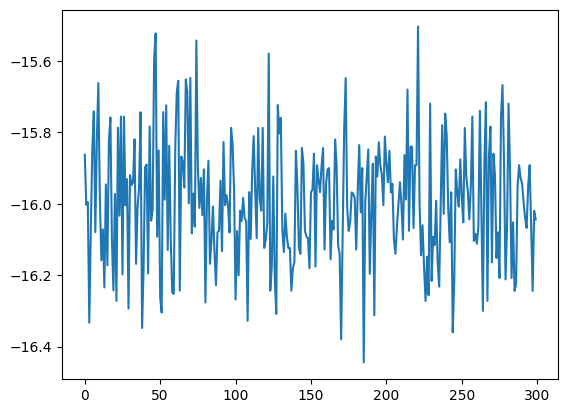

In [56]:
plt.plot(logger.data['Energy']['iters'], logger.data['Energy']['Mean'])